In [1]:
import geopandas as gpd
from shapely.geometry import Point, Polygon
import random
import matplotlib.pyplot as plt
import numpy as np

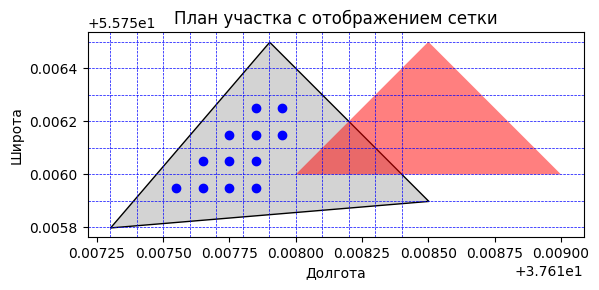

In [3]:

input_geojson = {
    "type": "FeatureCollection",
    "features": [
        {"type": "Feature", "properties": {"name": "Участок"}, 
         "geometry": {"type": "Polygon", "coordinates": [[[37.6173, 55.7558], [37.6179, 55.7565], [37.6185, 55.7559], [37.6173, 55.7558]]]}}
    ]
}

restrict_geojson = {
    "type": "FeatureCollection",
    "features": [
        {"type": "Feature", "properties": {"name": "Лесная зона", "restriction": "no_build"},
         "geometry": {"type": "Polygon", "coordinates": [[[37.6180, 55.7560], [37.6185, 55.7565], [37.6190, 55.7560], [37.6180, 55.7560]]]}}
    ]
}

# Загрузка границ участка
plot_boundary = gpd.GeoDataFrame.from_features(input_geojson["features"])
restrict_zones = gpd.GeoDataFrame.from_features(restrict_geojson["features"])

# Допустимый процент площади для застройки
allowed_building_percentage = 0.40

# Расчет площади участка и допустимой площади для застройки
total_area = plot_boundary.geometry.area.values[0]
allowed_area = total_area * allowed_building_percentage

# Функция для размещения объектов (например, зданий)
def place_buildings(plot_boundary, restrict_zones, allowed_area, min_distance):
    placed_buildings = []
    total_placed_area = 0
    
    # Определите границы для генерации точек
    x_min, y_min, x_max, y_max = plot_boundary.total_bounds

    # Создайте сетку для проверки
    grid_size = 0.0001  # Пример размера ячейки сетки (примерно 10 метров в градусах)
    x_points = np.arange(x_min, x_max, grid_size)
    y_points = np.arange(y_min, y_max, grid_size)

    for i in range(len(x_points) - 1):
        for j in range(len(y_points) - 1):
            # Проверка на запрет на строительство
            cell_polygon = Polygon([
                (x_points[i], y_points[j]),
                (x_points[i + 1], y_points[j]),
                (x_points[i + 1], y_points[j + 1]),
                (x_points[i], y_points[j + 1]),
            ])
            if plot_boundary.contains(cell_polygon).any() and not restrict_zones.intersects(cell_polygon).any():
                # Эмулируем здание и увеличиваем площадь
                building_size = min(grid_size ** 2, allowed_area - total_placed_area)  # Упрощение
                placed_buildings.append(cell_polygon.centroid)  # Добавляем центр ячейки как место здания
                total_placed_area += building_size
                if total_placed_area >= allowed_area:
                    break
        if total_placed_area >= allowed_area:
            break

    return placed_buildings

# Размещение объектов
placed_buildings = place_buildings(plot_boundary, restrict_zones, allowed_area, min_distance=10)

# Формирование GeoJSON результата
output_features = []
for idx, point in enumerate(placed_buildings):
    output_features.append({
        "type": "Feature",
        "properties": {"name": f"Здание {idx+1}"},
        "geometry": {
            "type": "Point",
            "coordinates": [point.x, point.y]
        }
    })

output_geojson = {
    "type": "FeatureCollection",
    "features": output_features
}

# Генерация карты
fig, ax = plt.subplots()
plot_boundary.plot(ax=ax, color='lightgrey', edgecolor='black')

restrict_zones.plot(ax=ax, color='red', alpha=0.5)

# Добавляем сетку на карту
x_min, y_min, x_max, y_max = plot_boundary.total_bounds
grid_size = 0.0001  # Размер ячейки сетки

for x in np.arange(x_min, x_max, grid_size):
    ax.axvline(x=x, color='blue', linestyle='--', linewidth=0.5)  # Вертикальные линии сетки
for y in np.arange(y_min, y_max, grid_size):
    ax.axhline(y=y, color='blue', linestyle='--', linewidth=0.5)  # Горизонтальные линии сетки

# Отображаем здания
for point in placed_buildings:
    ax.scatter(point.x, point.y, color='blue', marker='o')

plt.title("План участка с отображением сетки")
plt.xlabel("Долгота")
plt.ylabel("Широта")
plt.show()

# Сохранение GeoJSON результата
with open('output.geojson', 'w') as f:
    import json
    json.dump(output_geojson, f)
